In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Parameters ---
N       = 10_000  #number of neurons
K       = 1_000  #connectivity - each neuron connected to K different neurons

V_T     = 1.0 # voltage threshold
V_R     = 0.0 # voltage reset

nu      = 10*Hz #firing rate
J_0     = 1.0 
tau_m   = 10*ms #membrane time constant

I_0 = nu * J_0 * tau_m 
Iext_const = np.sqrt(K) * I_0 #constant excitatory current
w_inh = J_0/np.sqrt(K) # inhibitory input received

def T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const):
    '''a constant value needed for voltage to phase space transition
    '''
    ln = np.log((VT-I_ext)/(VR-Iext_const))
    return -tau * ln

def phi(V):
    '''
    takes unitless Voltage value, returns phi space
    '''
    Tfree = T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const)
    return - tau_m / Tfree *(np.log((V-Iext_const)/(V_R-Iext_const)))

def phi_inv(phi, C = Iext_const, tau_m = tau_m):
    '''Converts from phi space from voltage space
    '''
    Tfree = T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const)/ms
    exponent = - phi * Tfree / (tau_m/ms)
    return (V_R - C) * np.exp(exponent) + C

In [3]:
def run_w_startvector(runtime, startvector):   #enter the runtime in seconds but with the unit
    
    start_scope() 
    defaultclock.dt = 0.1*ms

    # makes use of all variables declared globally, i.e. V_f, V_t, nu, N, K...

    # --- Neuronmodell (Voltage-LIF) ---
    # tau_m dV/dt = -V + I(t) (1), with I(t)=sqrt(K)*I_0 - (J_0/sqrt(K))*sum delta(...)
    eqs = """
    dV/dt = (-V + I_ext)/tau_m : 1  #dimensionless
    I_ext : 1                       #dimensionless constant excitatory current
    """

    G = NeuronGroup(
        N,
        model=eqs,
        threshold="V >= V_T",
        reset="V = V_R",
        method="euler"
    )

    # Initialisierung
    G.V = startvector   #initialize voltage values to start vector
    G.I_ext = Iext_const   #initialize excitatory current with global value

    #connectivity probability
    p = K / (N-1)   # p in (0,1)

    seed(0)           # Brian2 seed
    S = Synapses(G, G, on_pre="V -= w_inh")  # when action potential occurs, decrease the voltage of post-synaptic neuron
    S.connect(condition='i!=j', p=p) # set recurrent connections with probability p, set all self recurrent connections to 0


    #sp_mon = SpikeMonitor(G)
    mon_all_V = StateMonitor(G, 'V', record=True) #((len(indices), len(t)))

    print(f"\nRunning simulation for T = {runtime}")

    run(runtime)
    mon_endvalues = np.array(G.V) #takes only final voltages

    return mon_endvalues, mon_all_V



In [4]:
# initial random vector of size 10k, a voltage value [0,1) for all 10k neurons
initial_randvector = np.random.rand(10000)

# run for 1s
runtime = 1*second
# V_0 is the voltage vector after 1second free run
V_0, trajectory_V_0  = run_w_startvector(runtime, initial_randvector)


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]



Running simulation for T = 1. s


In [5]:
#run V_0 for 10ms
runtime = 10*ms
V_1, trajectory_V_1  = run_w_startvector(runtime, V_0)


Running simulation for T = 10. ms


Helpful info. <br>
V_0: (N,). <br>
trajectory_V_0.V: (N,runtime) // runtime is in 0.1ms's. 


In [7]:
#convert to phase
phase_V_0 = phi(V_0) # (N,), same dimension

#create and add the random vector (perturb in phase space)
r = np.random.normal(0,1,N)
r /= np.linalg.norm(r)
phase_V_0_shift = phase_V_0 + r

#convert the perturbed phase vector back to voltage space
# this means we slightly altered the V_0
V_0e = phi_inv(phase_V_0_shift)

In [8]:
#run from the slighly altered starting point V0_e
V_1e, trajectory_V_1e = run_w_startvector(runtime, V_0e)

# calculate difference of voltage vectors in phase space between original V0 and altered V0e
# trajectories.V: (N,runtime), we subtract each entries of the (N,runtime) matrix
phase_V_5_shift=phi(trajectory_V_1.V)
phase_V_5e_shift=phi(trajectory_V_1e.V)
diff_eps_phase = np.abs(phase_V_5_shift - phase_V_5e_shift)

# sum the difference over all neurons per timestep and normalize by dividing to N
# final vector: (runtime,)
diff_over_neurons_normalized = diff_eps_phase.sum(axis=0) / N



Running simulation for T = 10. ms


In [9]:
def plot_time_difference(diff_over_neurons_normalized,runtime):
    '''
    plot voltage difference against time
    '''
    plt.plot(diff_over_neurons_normalized)
    plt.yscale('log')
    plt.xlabel(f'runtime {runtime} / timestep (0.1ms)')
    plt.ylabel(f'average phase difference of 10k neurons')
    plt.title(r'Time dependent difference $D_{\phi}(t) = \|\phi(V(t)) - \phi(V_{\varepsilon}(t))\|$')
    plt.legend()

WARNING    C:\Users\thorb\AppData\Local\Temp\ipykernel_20884\3673977566.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
 [py.warnings]


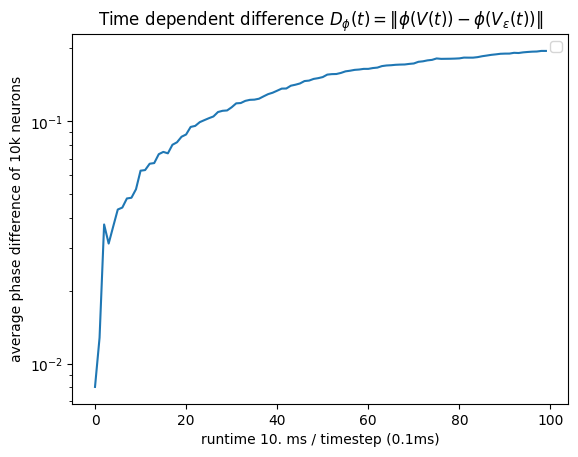

In [10]:
plot_time_difference(diff_over_neurons_normalized,10*ms) # 1*s

3. <br>
In this particular perturbation (e=1), after running V1 and V1e for 10ms seconds (100 timesteps), the time dependent difference between two initial voltage values of the neurons increase and stabilize around 0.2 mV. This means that the perturbed initial voltage starting point finds stability in a flux tube different than the unperturbed voltage.

In [11]:
# find an epsilon that decreases (converges in the same flux tube), and an epsilon that increases.
# we already have our normalized random vector r = np.random.normal(0,1,N),  r /= np.linalg.norm(r)
# so we scale it up and down and try to find bifurcation values for epsilon in our system 
# - leading to convergence of the same flux tube vs different flux tube
epsilon_array=[0.001,0.002,0.003,0.004,0.005]

In [12]:
def simulate_epsilon_differences(eps_array,num_realizations,V0,runtime):
    phase_V0=phi(V0)
    # run unperturbed vector V0
    V1, trajectory_V1 = run_w_startvector(runtime, V0)
    phase_V1_shift=phi(trajectory_V1.V)
        
    divergence_probabilities = []

    for eps in eps_array:
        divergence_count = 0

        for realization in range(num_realizations):
            # add perturbation to V0
            np.random.seed(realization)
            r1 = np.random.normal(0,1,N)
            r1 /= np.linalg.norm(r1)
            phase_V0e_shift = phase_V0 + (eps*r1)
            V0e=phi_inv(phase_V0e_shift)
            
            # run the perturbed vector V0e
            print(f'epsilon = {eps}')
            V1e, trajectory_V1e = run_w_startvector(runtime, V0e)
            
            # calculate difference between trajectories of original and perturbed vectures
            phase_V1e_shift=phi(trajectory_V1e.V)
            diff_eps_phase = np.abs(phase_V1_shift - phase_V1e_shift)
            diff_over_neurons_normalized = diff_eps_phase.sum(axis=0) / N

            # plt.figure()
            # plot_time_difference(diff_over_neurons_normalized, runtime)
            # plt.show()

            # calculate probability of distance between original and perturbed vectors increasing
            if diff_over_neurons_normalized[-1] > diff_over_neurons_normalized[0]:
                divergence_count += 1
                
        divergence_probabilities.append(divergence_count / num_realizations)

    return np.array(eps_array), np.array(divergence_probabilities)

In [12]:
# simulate_epsilon_differences(epsilon_array,V_0,20*ms)

4. <br>
We observe that for e in [0.001,0.002], the difference in phase space between the original and perturbed vector decreases over time. This implies that a perturbation with e= 0.001 or e=0.002, for the initial location in the phase space is too small to exit the current flux tube. So the perturbed vector converges on the same stability as the original vector <br>
<br>
However,for e in [0.004,0.005], the difference in phase decreases over time. Such perturbations are strong enough to change the flux tube of the original vector. 
<br>
To be safe, we chose two epsilon values: e = 0.001 to demonstrate decreasing distance, e=0.01 to demonstrate increasing distance. We repeat the observation 3 times, with different initial random r vectors for both cases. 
<br>
We observe that for e=0.001 for all 3 of our simulations, the original and perturbed vectors converge to same vector. Whereas, for e=0.01, all 3 runs converge to different vectors.

In [13]:
# reproduce epsilon = 0.001, and epsilon = 0.005 for 3 observations. 
epsilon_array1=[0.001] * 3
epsilon_array2=[0.01] * 3
# simulate_epsilon_differences(epsilon_array1,V_0,20*ms)
# simulate_epsilon_differences(epsilon_array2,V_0,20*ms)


5.


Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10. ms
epsilon = 1e-05

Running simulation for T = 10.

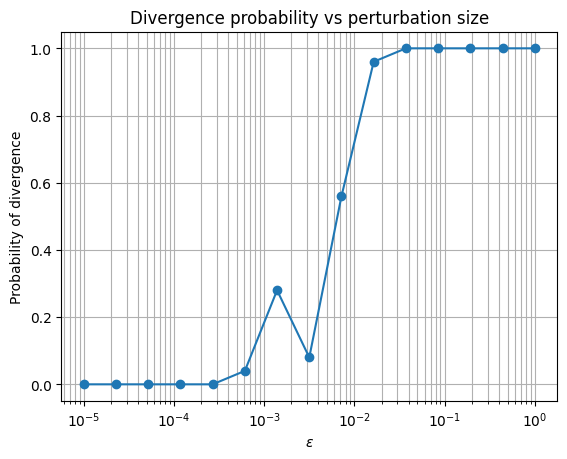

In [14]:
# repeat with 15 values of e between 10^-5 and 10^0 (logscale separated)
# for 50 realizations per epsilon. Asses for each e, number of realizations where difference D_phi(t) doesn't go to zero. 
# i.e. (test final value of D_phi(t) different than D_phi(0))

eps_array = np.logspace(-5, 0, 15)
eps, prob = simulate_epsilon_differences(eps_array, 50, V_0, runtime)

plt.figure()
plt.semilogx(eps, prob, marker='o')
plt.xlabel(r'$\epsilon$')
plt.ylabel('Probability of divergence')
plt.title('Divergence probability vs perturbation size')
plt.grid(True, which='both')
plt.show()



In [15]:
print(prob)
print(eps)

[0.   0.   0.   0.   0.   0.04 0.28 0.08 0.56 0.96 1.   1.   1.   1.
 1.  ]
[1.00000000e-05 2.27584593e-05 5.17947468e-05 1.17876863e-04
 2.68269580e-04 6.10540230e-04 1.38949549e-03 3.16227766e-03
 7.19685673e-03 1.63789371e-02 3.72759372e-02 8.48342898e-02
 1.93069773e-01 4.39397056e-01 1.00000000e+00]


We observe that results look pretty similar to figure 5b. <br>
for epsilon <= 10^(-4), probability(observing divergence between original and perturbed vector)=0 <br>
for 0.001 < eps < 0.003, prob (observing divergence between original and perturbed vector) = 0.5 <br>
for eps > 0.015, prob = 1. 

6.

In [ ]:
p_vec = np.random.normal(0,1,N)
p_vec /= np.linalg.norm(p_vec)

q_vec = np.random.normal(0,1,N)
q_vec /= np.linalg.norm(q_vec)

# put this into a 20x20 matrix
Vij = np.zeros((20,20,10000))

for a in range(0,20):
    for b in range(0,20):
        Vij[a,b] = (-0.1 + a * 0.01) * p_vec + (-0.1 + b * 0.01) * q_vec

In [ ]:
# run this for the 400 conditions
runtime = 10*ms

# create a matrix to store the resulting end vectors
# add a dimension of 1 to add the flux tube group later
end_matrix = np.zeros((20,20,1,10000))


for a in range(0,4):
    for b in range(0,4):
        end_matrix[a,b,0], c = run_w_startvector(runtime, Vij[a,b])


In [ ]:
end_matrix[0,1,0]

array([0.28315949, 0.28338572, 0.28267881, ..., 0.2833078 , 0.28298228,
       0.28308277], shape=(10000,))